# Проверка гипотез по увеличению выручки в интернет-магазине —
оценить результаты A/B тест

### Описание проекта
В крупном интернет-магазине  подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.  

Описание данных  
Файл /datasets/hypothesis.csv.  
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
Файл /datasets/orders.csv.  
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  
Файл /datasets/visitors.csv.  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

### План:
1) Приоритезировать гипотезы: применить фреймворки ICE и  RICE, объяснить разницу в их результатах
2) Проанализировать A/B-тесте по "сырым" и "очищенных" данным, определить границы аномальных заказов, графически сравнить результы групп A и В.
3) На основании анализа А/В теста сделать вывод о продожении/прекращении теста.

# Подготовка

In [1]:
#Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
import scipy.stats as stats
import datetime as dt
import math

In [2]:
# формируем датасеты
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [5]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


0

In [6]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [7]:
visitors.info()
visitors.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


0

In [8]:
# скоректируем формат
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
hypothesis.columns = map(str.lower, hypothesis.columns)

Дубликаты отсутствуют, даты приведены к нужному формату, и столбцы в нижем регистре можно продоложать.

# Приоритезация гипотез

### Применение фреймворка ICE для приоритизации гипотез. 

In [9]:
# Приминяем ICE для гипотез
hypothesis['ICE'] = ( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


### Применение фреймворка RICE для приоритизации гипотез.

In [10]:
# Приминяем RICE для гипотез
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Подведем промежуточный вывод.

In [11]:
pd.set_option('display.max_columns', None)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


Согластно ICE лидирует 8 гипотиза, RICE - 7. При этом в обоих методиках в топ-5 входят гипотезы 0,2,6,7,8. Различие обосновано использование в RICE показателя охвата пользователей,как видно из данных у 7 гипотезы он значительно больше чем у остальных.

# Анализ A/B-теста

### Строим график кумулятивной выручки по группам

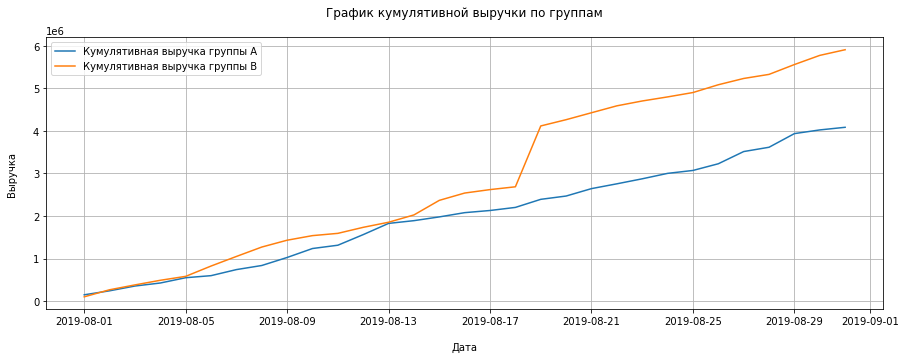

In [12]:
#Создаем массив данных
grouped_data = orders[['date','group']].drop_duplicates()

#Агрегируем кумулятивные данные
agg_orders= grouped_data.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transactionId' : pd.Series.nunique, 
                                          'visitorId' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

agg_visitors= grouped_data.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#объединим данные и переименуем столбцы
cum_data = agg_orders.merge(agg_visitors, left_on=['date', 'group'], right_on=['date', 'group'])
cum_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# создаем датафрейм по группам
cum_group_a = cum_data[cum_data['group']=='A'][['date','revenue', 'orders']]
cum_group_b = cum_data[cum_data['group']=='B'][['date','revenue', 'orders']]

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#строим граффик
plt.figure(figsize=(15,5))
plt.plot(cum_group_a['date'], cum_group_a['revenue'], label='Кумулятивная выручка группы A')
plt.plot(cum_group_b['date'], cum_group_b['revenue'], label='Кумулятивная выручка группы B')
plt.title('График кумулятивной выручки по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Выручка\n')
plt.grid()
plt.legend() ;

Кумулятивная выручка группы В около 19 августа резко возросла, по видимо увеличился какой-то(возможно не один, при дальнейшем анализе узнаем какой именно) показатель продаж.

### Строим график кумулятивного среднего чека по группам

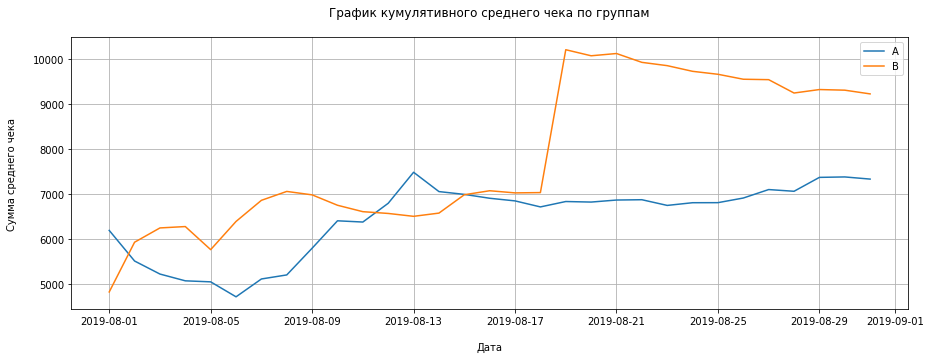

In [13]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cum_group_a['date'], cum_group_a['revenue']/cum_group_a['orders'], label='A')
plt.plot(cum_group_b['date'], cum_group_b['revenue']/cum_group_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Сумма среднего чека\n')
plt.legend() ;

Согластно граффику группы кумулятовное значение среднего чека группы В резко изменяется, как и значение кумулятивной выручки, в районе 19 августа, скорее всего в этот день произошел выброс( в дальнейших граффиках он будет фигурировать - покупка в 2000000 при наиболее распостраненных покупках не превышающих 20000). К концу месяца граффики стремяться к среднему с преобладанием группы В над А.

### Строим график относительного изменения кумулятивного среднего чека группы B к группе A

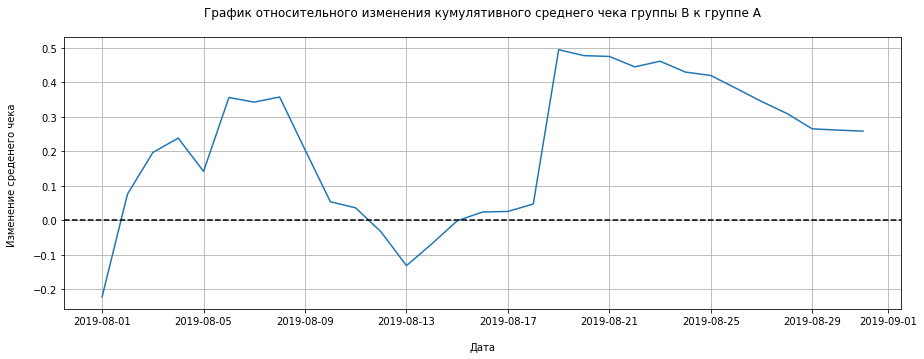

In [14]:
# объединяем данные
sum_cum_revenue = cum_group_a.merge(cum_group_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# строим граффик
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(sum_cum_revenue['date'], (sum_cum_revenue['revenueB']/sum_cum_revenue['ordersB'])/(sum_cum_revenue['revenueA']/sum_cum_revenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Изменение среденего чека \n')
plt.axhline(y=0, color='black', linestyle='--') ;

Граффик достаточно сильно колеблиться в определенных моментах, что схоже с 2 предыдущими графиками. Скорее всего в эти моменты и произошли аномалии.

### Строим график кумулятивного среднего количества заказов на посетителя по группам

''

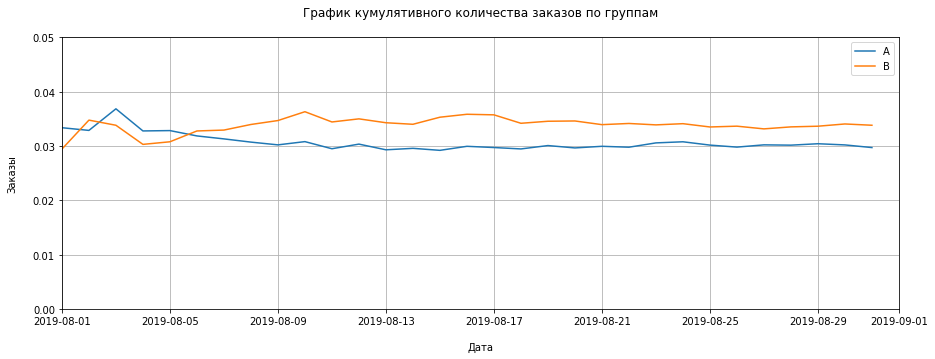

In [15]:
# считаем кумулятивное среднее количество заказов
cum_data['conversion'] = cum_data['orders']/cum_data['visitors']

# отделяем группы
cum_data_a = cum_data[cum_data['group']=='A']
cum_data_b = cum_data[cum_data['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cum_data_a['date'], cum_data_a['conversion'], label='A')
plt.plot(cum_data_b['date'], cum_data_b['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного количества заказов по группам\n  ')
plt.xlabel('\nДата')
plt.ylabel('Заказы\n')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
;

Группа В стабильно показывает немного более высокий уровень заказов, за исключением начала августа

### Строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

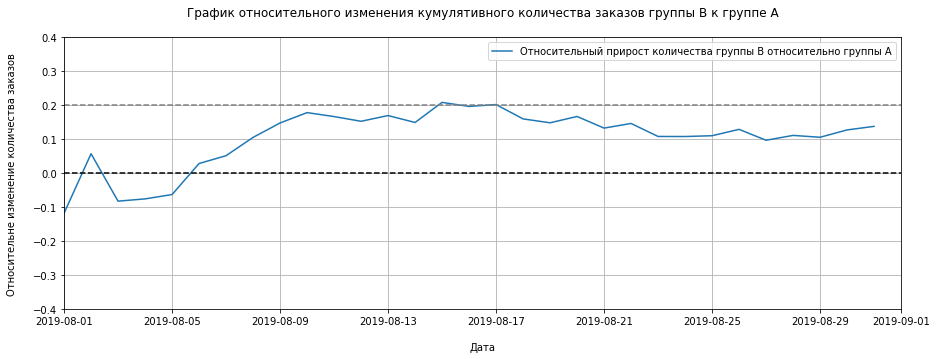

In [16]:
cum_conv_b_to_a = cum_data_a[['date','conversion']].merge(cum_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cum_conv_b_to_a['date'], cum_conv_b_to_a['conversionB']/cum_conv_b_to_a['conversionA']-1, label="Относительный прирост количества группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4])
plt.title('График относительного изменения кумулятивного количества заказов группы B к группе A\n  ')
plt.xlabel('\nДата')
plt.ylabel('Относительне изменение количества заказов\n') ;

Как и в предыдущем граффике за исключением начала августа группа В стабильно лидирует

### Строим точечный график количества заказов по пользователям

''

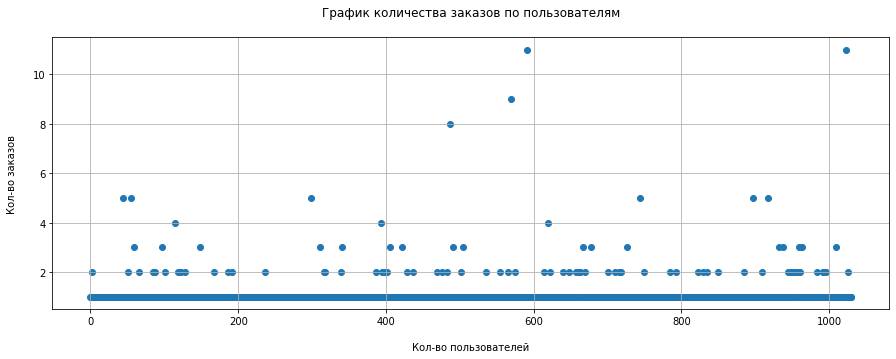

In [17]:
orders_by_users = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})
orders_by_users.columns = ['user_id','orders']

orders_by_users.sort_values(by='orders',ascending=False).head(10)

plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Кол-во заказов\n')
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders']) 
;

Большинство покупателей ограничились одной покупкой, покупателей совершивших от 2 до 5 покупок встретить значительно тяжелее, но они присутсвуют. Так же можнло заметить 4 выброса.

<div class="alert alert-success">
    <b>✅ Комментарий ревьюера:</b>

График построен верно, с выводом согласен.
</div>

### Посчитайем 95-й и 99-й перцентили количества заказов на пользователя. Выбераем границу для определения аномальных пользователей

In [18]:
print(np.percentile(orders_by_users['orders'], [95, 99]))
orders_by_users.max()

[2. 4.]


user_id    4283872382
orders             11
dtype: int64

Максимальное колличество заказов 11, на 99 персентили количество заказов 4, принимаем ёё за границу аномалий.

### Строим точечный график стоимостей заказов

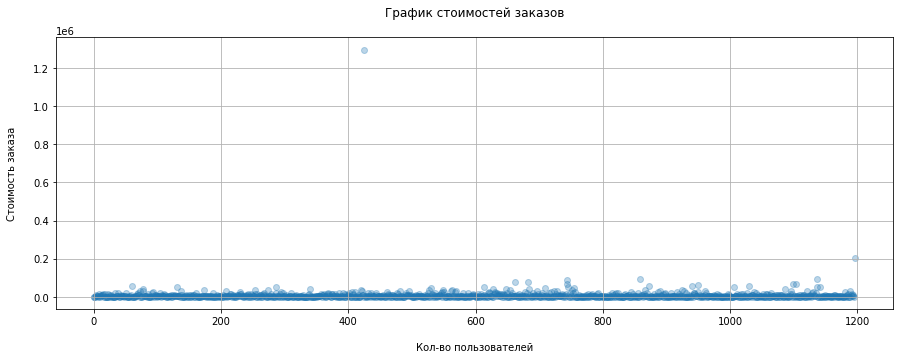

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов\n ')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(x_values, orders['revenue'], alpha=0.3);

Видна пара аномальных вабросов, остальная масса покупателей весьма умеренна в своих тратах

<div class="alert alert-warning">
    <b>⚠️ Комментарий ревьюера:</b>
    
Все верно, из-за двух выбросов график стал неинформативным. Давай сделаем еще один график без выбросов.
</div>

<div class="alert alert-info">
    <b>Добавилл график,отфильстованный по заказам авным или менее 200000, так как на предыдущем графике более этого уровня только 2 выброса</b>

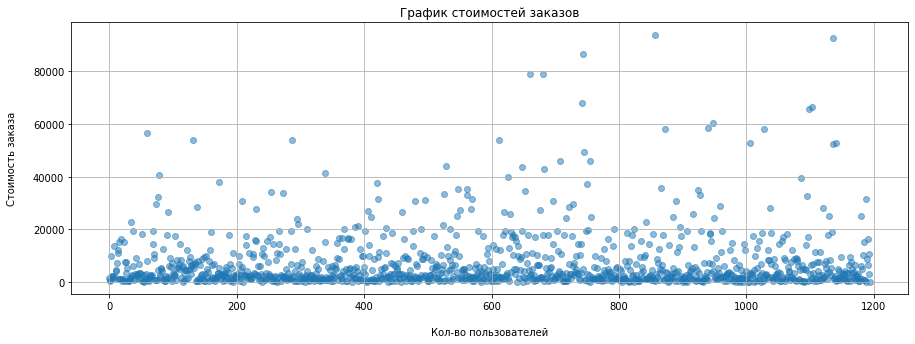

In [20]:
filtred_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(filtred_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.xlabel('\nКол-во пользователей')
plt.ylabel('Стоимость заказа\n')
plt.scatter(xn_values, filtred_orders, alpha=0.5);

Основная масса заказов не превышает 20000

### Считаем 95-й и 99-й перцентили стоимости заказов

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

In [22]:
orders['revenue'].max()

1294500

Максимальный заказ превышет миллион, установим предельную границу на 99 перцентили в 58233

### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Формулируем гипотезы:
Нулевая - среднее количество заказов групп А  и  В равны
Альтернативная - среднее количество заказов группы А не равно группе В

In [23]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [24]:
#проведем тестирование
alpha = 0.05
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

0.01679
0.138


Значение p-value меньше 0,05 , отвергаем нулевую гипотезу. Различие в заказах между группами составляет 13,8% в пользу группы В

### Посчитайем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Формулируем гипотезы:
Нулевая - средний чек группы А превосходит средний чкк группы В
Альтернативная - средний чек группы А не превосходит среднему группы В

In [25]:
#проведем тестирование
alpha = 0.05
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.729
0.259
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу - значение -value значительно выше 0,05. Средний чек группы А не больше среднего чека группы В.  Разница в среднем чеке группы В на 26% больше

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [26]:
# очистим данные
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

Формулируем гипотезы:
Нулевая - среднее количество заказов группы А  выше группы В
Альтернативная - среднее количество заказов группы А не выше группы В

In [27]:
#проведем тестирование
alpha = 0.05
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01438
0.153


Отвергаем нулевую теорию, как и в случае с "сырыми" данными группа В лучше, но преводство учеличилось до 15,3%

### Посчием статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Формулируем гипотезы:
Нулевая - статистичекой разницы в средних чеках между группами нет
Альтернативная - статистически значимые отличия присутствуют

In [28]:
#проведем тестирование
alpha = 0.05
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.851
-0.006


Принимаем нулевую гипотезу - разница между среднии чеками незанчителна, средний чек группы В после очистки оказался немного ниже среднего чека группы А, хотя до очистки был значительно больше

### Принимаем решение по результатам теста

### Решение - остановить тест, зафиксировав победу группы В

Обоснование - графики кумулятивных показателей, а так же среднее количество заказов указывают на лидерство группы В. Группа А немного лучше в аспекте среднего чека, но это преобладание не является статистически значимым.